This Jupyter Notebook provides an interactive script to assign translations to the characters recognized by the `syrocr getchars` program.

In [1]:
# First, import some libraries
import os.path, json
from syrocr.images import Im, AvgIm
# https://stackoverflow.com/a/32370538
# usage: display(image)
from IPython.core.display import display

In [2]:
# Then, locate directories and file names

img_dir = 'example'
json_dir = 'example'
src_img_ext = '.tif'
lines_file_ext = '_lines.json'
textlines_file_ext = '_textlines.json'
tables_file = os.path.join(json_dir, 'test_tables.json')

# ... and load the tables file to the tables dict
with open(tables_file, 'r') as f:
    tables = json.load(f)

In [3]:
# Define some functions

# TODO textsize should be available in line dict
def get_textsize(linetype, section):
    if section == 'main' and linetype in ('text', 'pagenr'):
        textsize = 'normal'
    else:
        textsize = 'small'
    return textsize

# we are mainly interested in the 'main' section,
# so for now we ignore 'marginl' and 'marginr'
section = 'main'

def get_filenames():
    with os.scandir(img_dir) as sd:
        for dir_entry in sorted(sd, key = lambda x: x.name):
            if dir_entry.is_file() and dir_entry.name.endswith(src_img_ext):
                basename = os.path.splitext(dir_entry.name)[0]
                img_file = dir_entry.path
                lines_file = os.path.join(json_dir, basename + lines_file_ext)
                textlines_file = os.path.join(json_dir, basename + textlines_file_ext)
                yield basename, img_file, lines_file, textlines_file

def get_key(basename, line_num, c_num, entry, table):
    c_id, d, keyoverride, box = entry
    c = table[c_id]
    if c['key'] is None:
        print(f'page {basename} line {line_num} character {c_num} id {c_id}')
        avgim = AvgIm(c['avgim']['base64_str'], c['avgim']['baseline'], c['avgim']['width'], c['avgim']['height'])
        display(avgim.maxtoblack(invert=True))
        key = input().split()
        table[c_id]['key'] = {
            'tr':     '' if not key else key.pop(0),
            'script': '' if not key or key[0].isdigit() else key.pop(0),
            'dist':   None if not key else int(key.pop(0)),
        }
        return table[c_id]['key']

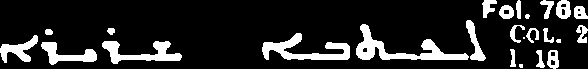

Line 2 textsize small
page mitchell2_test-01 line 2 character 0 id 10


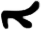

'
{'tr': "'", 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 1 id 11


r
{'tr': 'r', 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 2 id 12


y
{'tr': 'y', 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 4 id 13


$
{'tr': '$', 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 5 id 14


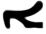

'
{'tr': "'", 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 6 id 15


b
{'tr': 'b', 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 7 id 16


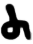

t
{'tr': 't', 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 8 id 17


k
{'tr': 'k', 'script': '', 'dist': None}
page mitchell2_test-01 line 2 character 9 id 18


KeyboardInterrupt: 

In [4]:
# Now, we go over the json files, and for every character
# without key, prompt for translation

for basename, img_file, lines_file, textlines_file in get_filenames():
    im = Im(img_file)
    with open(lines_file, 'r') as f:
        lines = json.load(f)
    with open(textlines_file, 'r') as f:
        text = json.load(f)

    for line, textline in zip(lines, text):
        if line['type'] != 'column' or line['main'] is None:
            continue
        textsize = get_textsize(line['type'], section)
        table = tables[textsize]
        display(im.crop(line['main']))
        print('Line', line['num'], 'textsize', textsize)
        for i, entry in enumerate(textline[section]):
            key = get_key(basename, line['num'], i, entry, table)
            if key is not None:
                print(key)
#
# Final letters: kaf, indicated with capital K; nun, indicated with capital N; mem, capital M
# Dotless dalath/rish: indicated with capital D
# TODO misplaced dot below Sade, that should be shifted from before to after Sade: #>
# TODO misplaced? dot below mem (with dot above), that properly belongs to following nun(?): m^# (id 312)

In [5]:
# cell for checking or updating values
c_id = 13

c = tables['small'][c_id]
display(AvgIm(c['avgim']['base64_str'],
              c['avgim']['baseline'],
              c['avgim']['width'],
              c['avgim']['height']).maxtoblack(invert=True))

c['key']['tr']

'$'

In [6]:
# When all is good, save the tables directory back to file.

# dialogue to prevent accidental writing to tables file
if input(f'Type \'yes indeed\' to save the tables dict to {tables_file}:\n') == 'yes indeed':
    with open(tables_file, 'w') as f:
        json.dump(tables, f)
    print('Saved!')
else:
    print('Not saved.')

Type 'yes indeed' to save the tables dict to example/test_tables.json:
no thanks
Not saved.


In [ ]:
# Search for ambiguously encoded characters

for basename, img_file, lines_file, textlines_file in get_filenames():
    with open(lines_file, 'r') as f:
        lines = json.load(f)
    with open(textlines_file, 'r') as f:
        text = json.load(f)
        
    for line, textline in zip(lines, text):
        if line['type'] != 'column':
            continue
        textsize = get_textsize(line['type'], section)
        table = tables[textsize]
        stack = None
        for i, entry in enumerate(textline[section]):
            c_id, connections, keyoverride, box = entry
            tr = table[c_id]['key']['tr'] if table[c_id]['key'] else None
            script = table[c_id]['key']['script'] if table[c_id]['key'] else None
            pr_tr = table[stack[0]]['key']['tr'] if stack and table[stack[0]]['key'] else None
            if ((pr_tr and pr_tr[-1] == '+' and tr != '+' + pr_tr[:-1])
                or ('+' in tr[:-1] and (not pr_tr or not '+' in pr_tr))
                or '?' in tr or (pr_tr and pr_tr[0] == '^') or (script == '' and tr.endswith('>'))):
                if stack:
                    print('prev:', stack, table[stack[0]]['key'])
                print(basename, line['num'], i, entry, table[c_id]['key'])
                im = Im(img_file)
                display(im.crop(line['main']))
            stack = entry

In [ ]:
# Search for ambiguously encoded characters

for basename, img_file, lines_file, textlines_file in get_filenames():
    with open(lines_file, 'r') as f:
        lines = json.load(f)
    with open(textlines_file, 'r') as f:
        text = json.load(f)
        
    for line, textline in zip(lines, text):
        if line['type'] != 'column':
            continue
        textsize = get_textsize(line['type'], section)
        table = tables[textsize]
        stack = None
        for i, entry in enumerate(textline[section]):
            c_id, connections, keyoverride, box = entry
            tr = table[c_id]['key']['tr'] if table[c_id]['key'] else None
            pr_tr = table[stack[0]]['key']['tr'] if stack and table[stack[0]]['key'] else None

            ### SEARCH LOCATION ###
#             if basename == 'mitchell2_test-05' and line['num'] == 44 and i in range(0,18): # tr == '$': # i == 14: # 
#                 print(basename, line['num'], i, entry, table[c_id]['key'])

            ### SEARCH C_ID ###
#             if c_id == 290:
#             if stack and stack[0] == 159:
#             if stack and pr_tr == '+S?N':
            if tr == 'y' and stack and pr_tr == 'S':
                if stack:
                    print('prev:', stack, table[stack[0]]['key'])
                print(basename, line['num'], i, entry, table[c_id]['key'])
                im = Im(img_file)
                display(im.crop(line['main']))
            stack = entry

#             if tr == 'w' and connections[0]:
#                 if stack:
#                     print('prev:', stack, table[stack[0]]['key'])
#                 print(basename, line['num'], i, entry, table[c_id]['key'])
# #                 print(f'  - [[\'{basename}\', {line["num"]}, {i}, {c_id}], \'q\']')
#                 im = Im(img_file)
#                 display(im.crop(line['main']))
#             stack = entry
